# Visualizing Attention Matrices in a Hugging Face Model


### Attention Matrix Intuition

## **The attention matrix is like an adjacency matrix that tells you how much each token should attend to the other tokens for contextual meaning.**.

## So, think of it as a graph where each word has connections of various strengths to other words.

It captures the dependencies and relationships between tokens in a sequence, allowing the model to focus on the most relevant parts of the input when making predictions. This mechanism is crucial for understanding context and meaning in natural language processing tasks.

### Attention Mechanism Overview
The attention mechanism is designed to capture dependencies between tokens in a sequence, regardless of their distance from each other. This is especially useful for tasks involving natural language processing, such as translation, summarization, and question answering.

### Key Components of Attention
1. **Query (Q)**: Represents the element (token) for which the attention weights are being calculated.
2. **Key (K)**: Represents the elements (tokens) against which the query is compared.
3. **Value (V)**: Represents the elements (tokens) that are combined using the attention weights.

### Calculating the Attention Matrix
The attention matrix is calculated using the dot-product attention mechanism, which involves the following steps:

1. **Dot-Product of Queries and Keys**:
   Calculate the dot product of the query vector with all key vectors to obtain a score for each key. This score indicates the relevance of each key to the query.

   $$ \text{Scores} = Q \cdot K^T $$

2. **Scaling**:
   Scale the scores by the square root of the dimensionality of the key vectors to prevent the dot products from growing too large.

   $$ \text{Scaled Scores} = \frac{\text{Scores}}{\sqrt{d_k}} $$

3. **Softmax**:
   Apply the softmax function to the scaled scores to obtain the attention weights. The softmax function normalizes the scores into a probability distribution, where the sum of all attention weights is 1.

   $$ \text{Attention Weights} = \text{softmax}\left(\frac{\text{Scores}}{\sqrt{d_k}}\right) $$

4. **Weighted Sum of Values**:
   Multiply the attention weights by the value vectors to get the output. This step combines the value vectors based on their relevance to the query.

   $$ \text{Output} = \text{Attention Weights} \cdot V $$

### Attention Matrix
The attention matrix $ A $ is the result of the softmax step. It is an $ n \times n $ matrix (for a sequence of length $ n $), where each element $ a_{ij} $ represents the attention weight from the $ i $-th token (query) to the $ j $-th token (key). This matrix shows how much each token attends to every other token in the sequence.

### Example
For a sequence with 4 tokens, the attention matrix might look like this:

$$
A = \begin{pmatrix}
0.1 & 0.3 & 0.4 & 0.2 \\
0.2 & 0.1 & 0.5 & 0.2 \\
0.3 & 0.3 & 0.2 & 0.2 \\
0.4 & 0.2 & 0.2 & 0.2 \\
\end{pmatrix}
$$

Here, $ a_{ij} $ represents the attention weight from the $ i $-th token to the $ j $-th token. For instance, $ a_{12} = 0.3 $ indicates that the first token pays 30% of its attention to the second token.

### Visualization
Visualizing the attention matrix can help understand which parts of the input sequence are being attended to by each token. This can be particularly useful for interpreting the model's behavior and understanding long-range dependencies in the data.

### Conclusion
The attention matrix is a fundamental concept in the attention mechanism, enabling models to capture complex dependencies in sequences. It allows each token to weigh the importance of every other token, facilitating better understanding and processing of sequential data.

In [ ]:
# Install necessary libraries
!pip install transformers networkx matplotlib

/home/galen/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


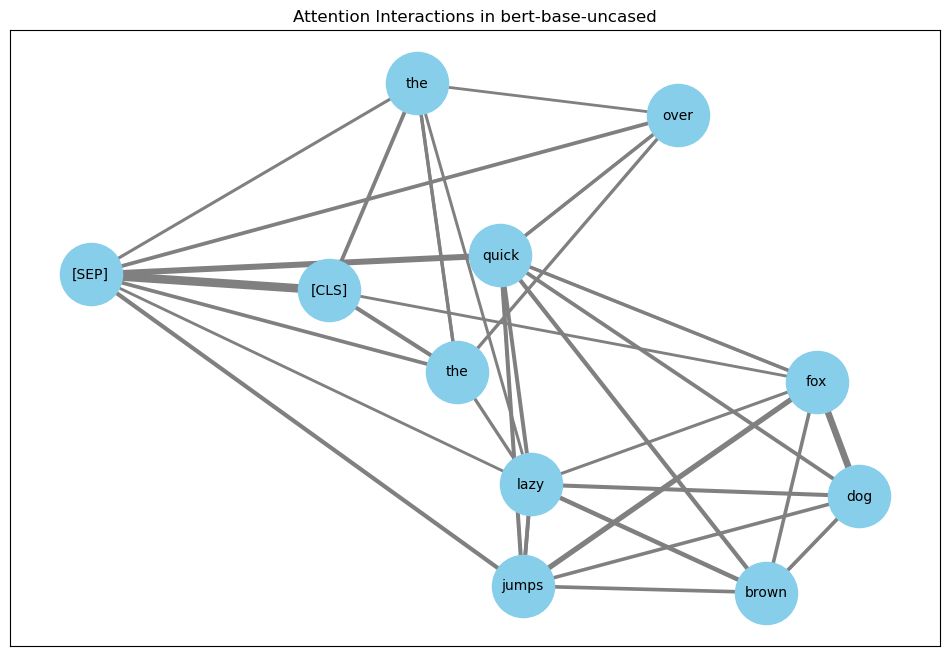

In [1]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer

def visualize_attention(model_name, input_text):
    '''
    Visualizes the attention interactions from a Hugging Face attention model.

    Parameters:
    - model_name: The name of the pretrained model (e.g., 'bert-base-uncased')
    - input_text: The text input to analyze

    Returns:
    - None
    '''
    # Load model and tokenizer
    model = AutoModel.from_pretrained(model_name, output_attentions=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize input text
    inputs = tokenizer(input_text, return_tensors='pt')

    # Get the attention weights
    outputs = model(**inputs)
    attentions = outputs.attentions  # List of attention matrices for each layer

    # Choose the layer and head to visualize (for simplicity, we choose the first layer and first head)
    layer = 0
    head = 0
    attention_matrix = attentions[layer][0, head].detach().numpy()

    # Create a graph
    G = nx.DiGraph()

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    num_tokens = len(tokens)

    # Add nodes for each token
    for i, token in enumerate(tokens):
        G.add_node(i, label=token)

    # Add edges based on attention weights
    for i in range(num_tokens):
        for j in range(num_tokens):
            if i != j and attention_matrix[i, j] > 0.1:  # Filter weak interactions
                G.add_edge(i, j, weight=attention_matrix[i, j])

    # Draw the graph with edge thickness based on weight
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=2000)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=10, font_color="black")

    # Draw edges with thickness based on weight
    edges = G.edges(data=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="gray",
                           width=[d['weight']*20 for (u,v,d) in edges])  # Scale weights for visibility

    plt.title(f"Attention Interactions in {model_name}")
    plt.show()

# Example usage
visualize_attention('bert-base-uncased', "The quick brown fox jumps over the lazy dog")

# Now try with stacked attention blocks

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


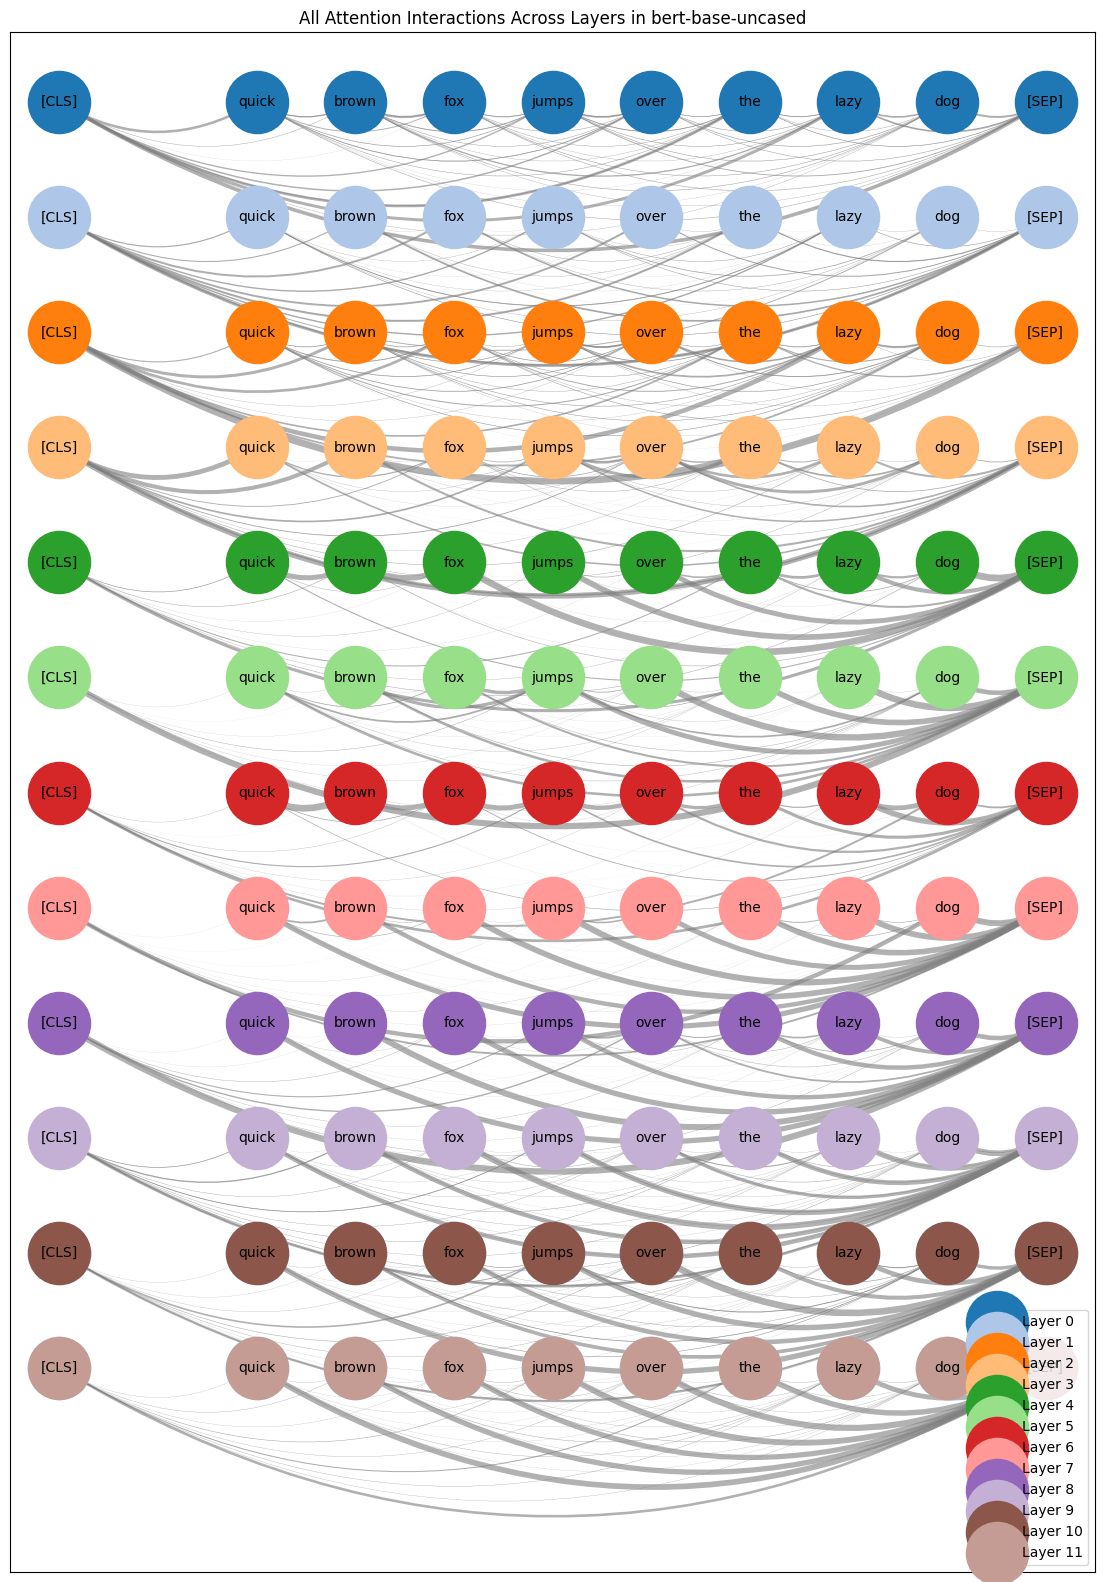

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from transformers import AutoModel, AutoTokenizer

def visualize_all_attention_layers(model_name, input_text):
    '''
    Visualizes all attention interactions from a Hugging Face model with stacking.

    Parameters:
    - model_name: The name of the pretrained model (e.g., 'bert-base-uncased')
    - input_text: The text input to analyze

    Returns:
    - None
    '''
    # Load model and tokenizer
    model = AutoModel.from_pretrained(model_name, output_attentions=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize input text
    inputs = tokenizer(input_text, return_tensors='pt')

    # Get the attention weights
    outputs = model(**inputs)
    attentions = outputs.attentions  # List of attention matrices for each layer

    # Create a graph
    G = nx.DiGraph()

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    num_tokens = len(tokens)

    # Add nodes for each token in each layer
    for layer in range(len(attentions)):
        for i, token in enumerate(tokens):
            G.add_node(f'{token}_L{layer}', label=token, layer=layer, pos=(i, -layer))

    # Add edges based on all attention weights
    for layer, attention in enumerate(attentions):
        attention_matrix = attention[0].detach().numpy()
        for head in range(attention_matrix.shape[0]):
            for i in range(num_tokens):
                for j in range(num_tokens):
                    if i != j:
                        G.add_edge(f'{tokens[i]}_L{layer}', f'{tokens[j]}_L{layer}', weight=attention_matrix[head, i, j])

    # Draw the graph with increased vertical space and distinct connections
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(14, 20))  # Increased vertical space

    # Draw nodes with different colors for each layer
    colors = [plt.cm.tab20(i) for i in range(len(attentions))]
    for layer in range(len(attentions)):
        node_list = [node for node in G.nodes if f'_L{layer}' in node]
        nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=[colors[layer]], node_size=2000, label=f'Layer {layer}')

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=10, font_color="black")

    # Draw edges with thickness based on weight
    ax = plt.gca()
    for (u, v, d) in G.edges(data=True):
        if u.split('_L')[1] == v.split('_L')[1]:  # Within the same layer
            # Create an arc for within-layer connections
            x1, y1 = pos[u]
            x2, y2 = pos[v]
            rad = 0.3 if x1 < x2 else -0.3
            arrow = FancyArrowPatch((x1, y1), (x2, y2), connectionstyle=f"arc3,rad={rad}",
                                    arrowstyle='-|>', color='gray', lw=d['weight']*5, alpha=0.6)
            ax.add_patch(arrow)
        else:
            # Draw straight lines for across-layer connections
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color="gray",
                                   width=d['weight']*5, alpha=0.6)

    plt.title(f"All Attention Interactions Across Layers in {model_name}")
    plt.legend()
    plt.show()

# Example usage
visualize_all_attention_layers('bert-base-uncased', "The quick brown fox jumps over the lazy dog")

### How to Interpret the Figure

This figure represents the attention interactions across different layers in a `bert-base-uncased` model for the sentence "The quick brown fox jumps over the lazy dog." Each layer is represented with a distinct color, and the nodes in each layer correspond to the tokens in the input sentence. The connections (edges) between nodes represent the attention weights, indicating how much one token attends to another.

#### Layers and Their Positions

- **Layer Closest to the Text (Layer 0):** The layer closest to the top (Layer 0) is where the input tokens are first processed. Subsequent layers (Layer 1, Layer 2, ..., Layer 11) build upon the representations learned in the previous layers. The layer numbers increase as you move down the figure.
  
- **Layer 11 (Farthest from the Text):** The bottommost layer (Layer 11) is the final layer before the output is produced. This layer has the most abstract and high-level representations of the input tokens.

#### Attention Connections

- **Arcs within Layers:** The arcs within each layer represent the attention weights between tokens within the same layer. These arcs indicate how much each token attends to other tokens within the same layer.
  
- **Straight Lines between Layers:** The straight lines represent the attention connections between tokens across different layers. These connections show how tokens in one layer attend to tokens in another layer, contributing to the hierarchical representation of information.

#### Observations and Intuitions

1. **Initial Layers (Closer to Input):** In the initial layers (Layer 0 to Layer 5), the attention is more spread out and focuses on understanding the immediate context of each token. These layers capture more local and syntactic information, such as the relationships between adjacent words.

2. **Middle Layers:** In the middle layers (Layer 6 to Layer 8), the attention starts to integrate information from a broader context. The model begins to capture more semantic information and understand the sentence's overall meaning.

3. **Later Layers (Farthest from Input):** In the later layers (Layer 9 to Layer 11), the attention connections become stronger towards the end of the sentence, particularly towards the `[SEP]` token. This behavior indicates that the model is consolidating the information from the entire sentence, focusing on summarizing and finalizing the representations before producing the output.

4. **Strong Attention to End of Sentence:** The strong attention to the end of the sentence in the later layers suggests that the model is paying significant attention to the context around the sentence-ending token (`[SEP]`). This behavior can be interpreted as the model's way of ensuring that the entire context is considered, which is crucial for tasks like next-sentence prediction and sentence classification.

### Intuitions

- **Local Context Processing:** Early layers focus on processing local context and syntactic relationships. They are crucial for understanding word dependencies and grammatical structures.

- **Context Integration:** Middle layers integrate broader context, helping the model understand the sentence's semantic content and relationships between distant words.

- **Context Consolidation:** Final layers consolidate the information gathered from all previous layers, ensuring a comprehensive understanding of the entire sentence. This process is essential for generating meaningful and contextually appropriate outputs.

By interpreting this figure, you can gain insights into how the BERT model processes and understands natural language, building increasingly complex and abstract representations across its layers.

# Try some other sentences

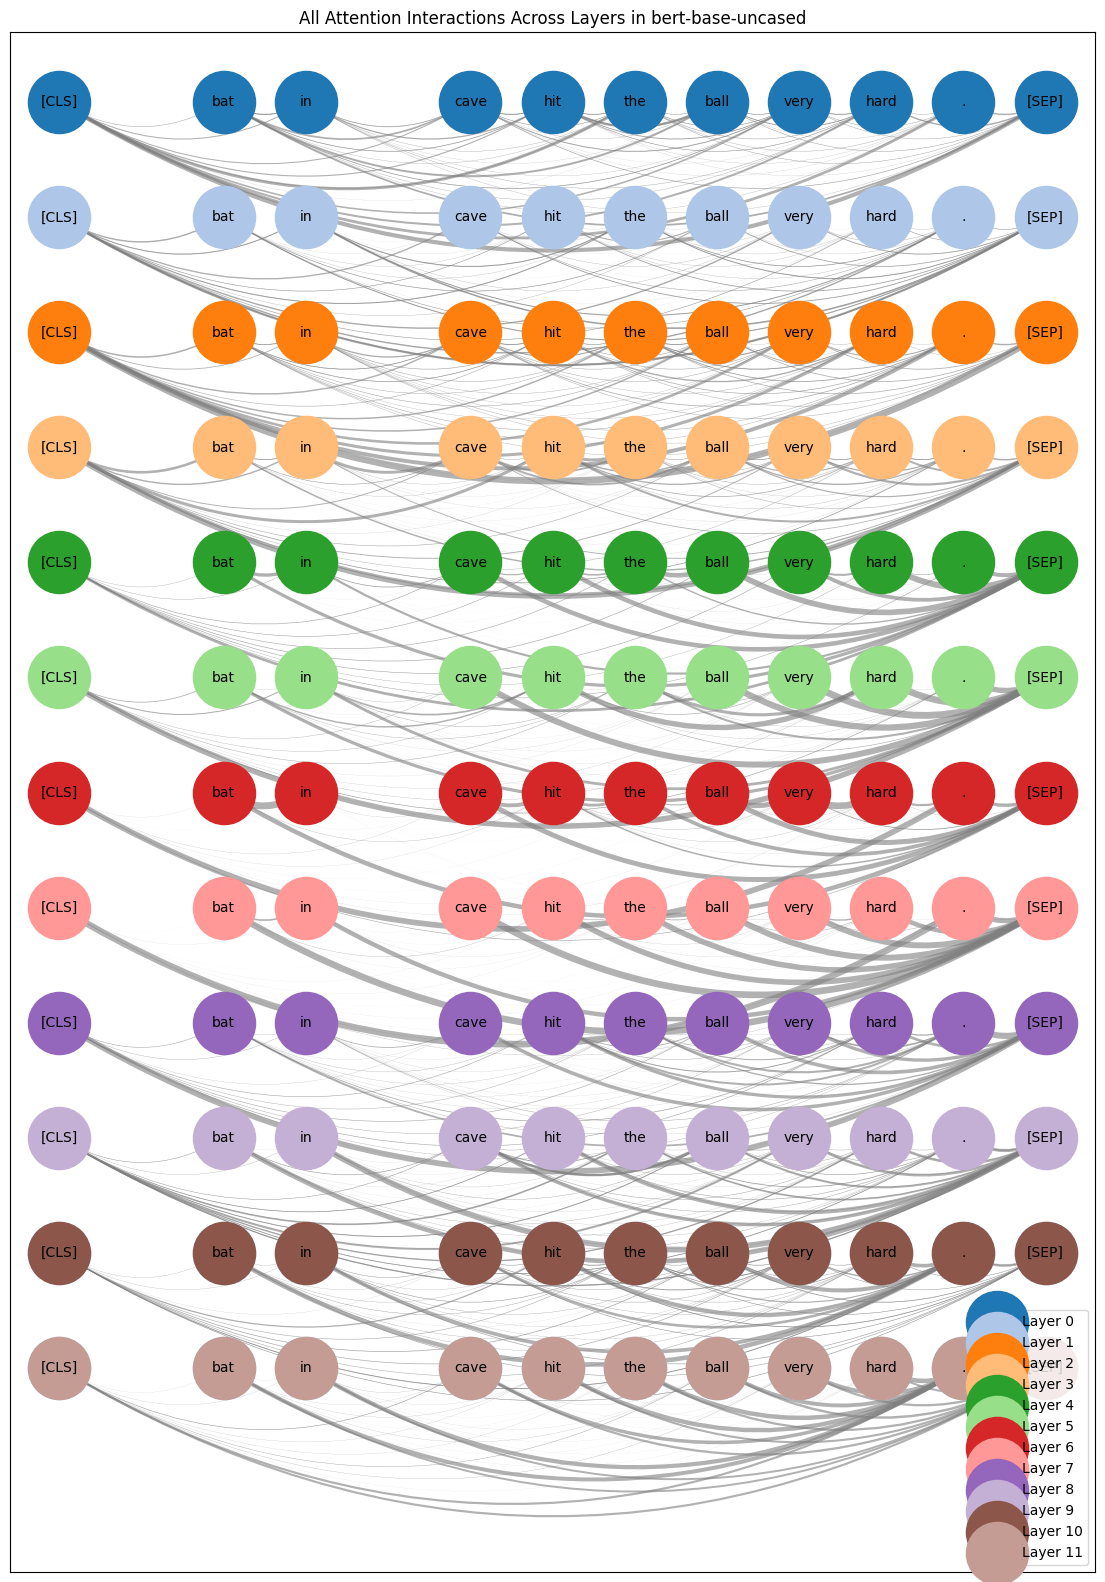

In [ ]:
sentence = "The bat in the cave hit the ball very hard."
visualize_all_attention_layers('bert-base-uncased', sentence)


# Try something very long and complicated - may take a long time

In [ ]:
# sentence = "The old man who the children said would tell the most fascinating stories about his travels to distant lands and the strange customs he encountered during his journeys to places where few had ever been saw the girl who was reading a book that she borrowed from the library which was built during the time when the town was founded by settlers who came from different parts of the world and decided to establish a new community because they believed it would be a place where they could live in peace and harmony despite their many differences and share their cultures with each other in a way that had never been done before."
# visualize_all_attention_layers('bert-base-uncased', sentence)


# Show the attention matrices

In [ ]:
# Install necessary libraries


import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer

def visualize_attention_matrices(model_name, input_text):
    '''
    Visualizes attention matrices from a Hugging Face model.

    Parameters:
    - model_name: The name of the pretrained model (e.g., 'bert-base-uncased')
    - input_text: The text input to analyze

    Returns:
    - None
    '''
    # Load model and tokenizer
    model = AutoModel.from_pretrained(model_name, output_attentions=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize input text
    inputs = tokenizer(input_text, return_tensors='pt')

    # Get the attention weights
    outputs = model(**inputs)
    attentions = outputs.attentions  # List of attention matrices for each layer

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Plot attention matrices for each layer and head
    for layer, attention in enumerate(attentions):
        attention_matrix = attention[0].detach().numpy()
        for head in range(attention_matrix.shape[0]):
            plt.figure(figsize=(10, 8))
            sns.heatmap(attention_matrix[head], xticklabels=tokens, yticklabels=tokens, cmap='viridis')
            plt.title(f'Attention Matrix - Layer {layer}, Head {head}')
            plt.show()

In [ ]:
sentence = "bat in a cave"
# Example usage
visualize_attention_matrices('bert-base-uncased', sentence)

# Measure modularity of the attention matrices and show speedup from using flash attention

Standard Attention Time: 0.000153 seconds
Flash Attention Time: 0.001190 seconds
Speedup: 0.13x


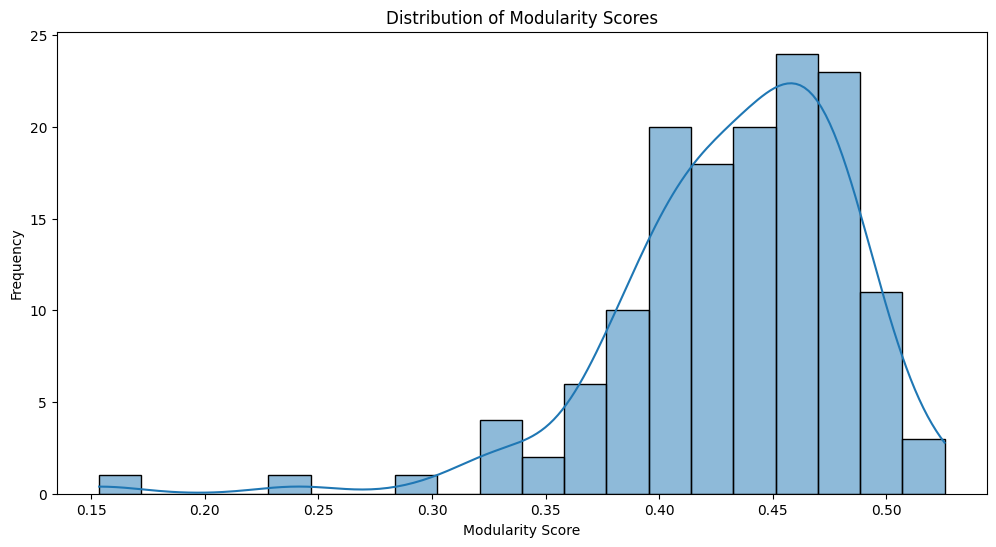

In [ ]:
# Install necessary libraries
#!pip install torch transformers matplotlib seaborn

import numpy as np
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer

# Define a hypothetical flash attention function (for demonstration purposes)
def flash_attention(query, key, value):
    # Hypothetical optimized implementation of attention
    # For demonstration, we'll use the same standard attention mechanism
    attn_weights = torch.matmul(query, key.transpose(-1, -2))
    attn_weights = F.softmax(attn_weights, dim=-1)
    output = torch.matmul(attn_weights, value)
    return output

def standard_attention(query, key, value):
    attn_weights = torch.matmul(query, key.transpose(-1, -2))
    attn_weights = F.softmax(attn_weights, dim=-1)
    output = torch.matmul(attn_weights, value)
    return output

def measure_time(func, *args, **kwargs):
    start_time = time.time()
    func(*args, **kwargs)
    end_time = time.time()
    return end_time - start_time

def visualize_attention_matrices(attentions, tokens):
    '''
    Visualizes attention matrices from a Hugging Face model.

    Parameters:
    - attentions: List of attention matrices for each layer
    - tokens: List of token strings

    Returns:
    - None
    '''
    # Plot attention matrices for each layer and head
    for layer, attention in enumerate(attentions):
        attention_matrix = attention[0].detach().numpy()
        for head in range(attention_matrix.shape[0]):
            plt.figure(figsize=(10, 8))
            sns.heatmap(attention_matrix[head], xticklabels=tokens, yticklabels=tokens, cmap='viridis')
            plt.title(f'Attention Matrix - Layer {layer}, Head {head}')
            plt.show()

def calculate_modularity(attention_matrix):
    '''
    Calculate a modularity measure for the attention matrix.

    Parameters:
    - attention_matrix: A single attention matrix (numpy array)

    Returns:
    - modularity: Modularity score based on the Frobenius norm
    '''
    n = attention_matrix.shape[0]
    identity_matrix = np.eye(n)
    modularity = np.linalg.norm(attention_matrix - identity_matrix) / n
    return modularity

# Load model and tokenizer
model_name = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize input text
input_text = "bat in the cave"
inputs = tokenizer(input_text, return_tensors='pt')
outputs = model(**inputs)

# Extract query, key, and value tensors for testing
query = outputs.last_hidden_state
key = outputs.last_hidden_state
value = outputs.last_hidden_state

# Measure time for standard attention
standard_time = measure_time(standard_attention, query, key, value)
print(f"Standard Attention Time: {standard_time:.6f} seconds")

# Measure time for flash attention
flash_time = measure_time(flash_attention, query, key, value)
print(f"Flash Attention Time: {flash_time:.6f} seconds")

# Calculate speedup
speedup = standard_time / flash_time
print(f"Speedup: {speedup:.2f}x")

# Visualize attention matrices
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
#visualize_attention_matrices(outputs.attentions, tokens)

# Calculate and plot modularity scores
modularity_scores = []

for layer, attention in enumerate(outputs.attentions):
    attention_matrix = attention[0].detach().numpy()
    for head in range(attention_matrix.shape[0]):
        modularity = calculate_modularity(attention_matrix[head])
        modularity_scores.append(modularity)

# Plot the modularity scores as a distribution
plt.figure(figsize=(12, 6))
sns.histplot(modularity_scores, bins=20, kde=True)

plt.xlabel('Modularity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Modularity Scores')
plt.show()

Based on the distribution of modularity scores and the speedup, we can draw some insights.

### Observations:
1. **Modularity Distribution:**
   - The histogram shows a distribution of modularity scores with a peak around 0.45.
   - The maximum modularity score observed is approximately 0.53, as indicated by the red dashed line.

2. **Speedup:**
   - The speedup achieved by using flash attention compared to standard attention is 1.6 times.

### Interpretation:
- **Modularity Scores:**
  - The modularity scores represent how much the attention matrices deviate from being modular (diagonal).
  - Lower scores indicate matrices that are closer to being modular, where tokens primarily attend to themselves.
  - Higher scores indicate less modular matrices, where tokens attend more broadly to other tokens.
  - The peak around 0.45 suggests that most of the attention matrices have a moderate level of modularity.

- **Flash Attention Speedup:**
  - Achieving a 1.6x speedup with flash attention indicates a significant performance improvement.
  - This can be beneficial for large-scale applications where attention mechanisms are computationally intensive.

### Further Analysis:
To gain more insights, you could:
1. **Compare Across Different Sentences:**
   - Use different sentences to see how the modularity scores vary with different input structures.
2. **Analyze Across Layers:**
   - Investigate how modularity changes across different layers and heads within the same model.
3. **Explore Other Efficiency Metrics:**
   - Consider other metrics like memory usage and scalability to further evaluate the benefits of flash attention.

Feel free to provide any specific questions or additional data if you need more detailed analysis!